In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense, Input, Lambda

from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,           # Apply random shear transformations
    zoom_range=0.2,            # Randomly zoom into images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels with nearest pixel values
)

# Define ImageDataGenerator for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Set batch size
batch_size = 32

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset 2000 image/archive (9) - Copy - Copy/Data/train',                 # Directory containing training images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    class_mode='categorical'   # Specify categorical labels
)

# Flow validation images in batches using validation_datagen
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset 2000 image/archive (9) - Copy - Copy/Data/test',            # Directory containing validation images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    class_mode='categorical'   # Specify categorical labels
)

Found 1447 images belonging to 3 classes.
Found 404 images belonging to 3 classes.


In [ ]:
# Load pre-trained models
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Freeze the convolutional layers of the base models
vgg_model.trainable = False
inception_model.trainable = False

In [ ]:
# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Obtain outputs from each base model
vgg_output = vgg_model(input_layer)
inception_output = inception_model(input_layer)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Apply global average pooling to the outputs from the base models
vgg_output = GlobalAveragePooling2D()(vgg_output)
inception_output = GlobalAveragePooling2D()(inception_output)

# Concatenate the outputs of the base models
concatenated_features = Concatenate()([vgg_output, inception_output])

In [ ]:

# Define an additional dense layer
x = Dense(512, activation='relu')(concatenated_features)
output_layer = Dense(3, activation='softmax')(x)


In [ ]:

ensemble_model = Model(inputs=input_layer, outputs=output_layer)
# Compile the model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_3[0][0]']             
                                                          8                                       
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_3[0][0]']             
                                                          4                                       
                                                                                              

In [ ]:
# Train the model
history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/20
46/46 [==============================] - 856s 18s/step - loss: 1.0214 - accuracy: 0.6980 - val_loss: 0.4691 - val_accuracy: 0.7995
Epoch 2/20
46/46 [==============================] - 56s 1s/step - loss: 0.3381 - accuracy: 0.8680 - val_loss: 0.2390 - val_accuracy: 0.9158
Epoch 3/20
46/46 [==============================] - 56s 1s/step - loss: 0.2832 - accuracy: 0.8950 - val_loss: 0.5160 - val_accuracy: 0.7946
Epoch 4/20
46/46 [==============================] - 55s 1s/step - loss: 0.2420 - accuracy: 0.9102 - val_loss: 0.2962 - val_accuracy: 0.8960
Epoch 5/20
46/46 [==============================] - 56s 1s/step - loss: 0.2322 - accuracy: 0.9109 - val_loss: 0.2792 - val_accuracy: 0.9010
Epoch 6/20
46/46 [==============================] - 58s 1s/step - loss: 0.2909 - accuracy: 0.8791 - val_loss: 0.2794 - val_accuracy: 0.9035
Epoch 7/20
46/46 [==============================] - 56s 1s/step - loss: 0.2025 - accuracy: 0.9212 - val_loss: 0.4004 - val_accuracy: 0.8639
Epoch 8/20
46/46 [

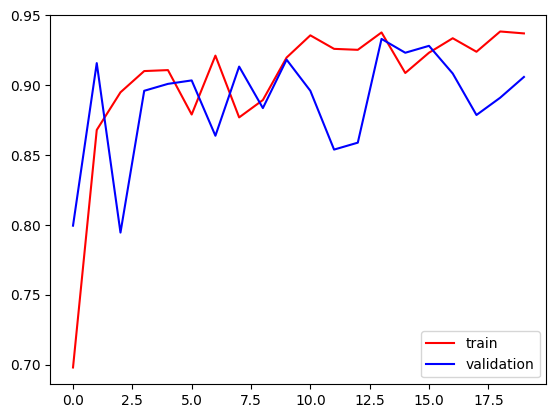

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

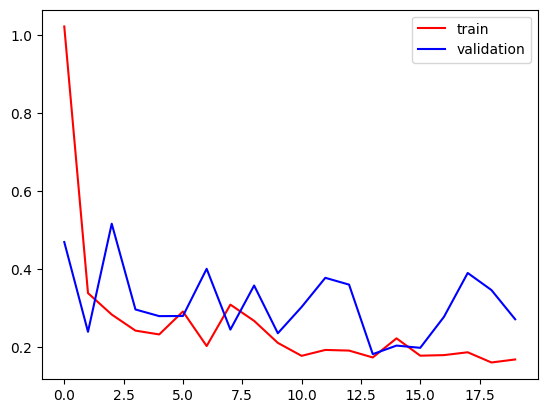

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model
loss, accuracy = ensemble_model.evaluate(validation_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 12s 769ms/step - loss: 0.2711 - accuracy: 0.9059
Test Loss: 0.2710888683795929
Test Accuracy: 0.905940592288971


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have already trained your model and loaded test data

# Evaluate the model on the training set
train_loss, train_accuracy = ensemble_model.evaluate(train_generator)

# Predict classes for training set
train_predictions = ensemble_model.predict(train_generator)
train_predicted_classes = np.argmax(train_predictions, axis=1)

# Get true labels for training set
train_true_classes = train_generator.classes

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Generate classification report for training set
train_report = classification_report(train_true_classes, train_predicted_classes, target_names=class_labels)

print("Training Classification Report:")
print(train_report)

# Evaluate the model on the validation set
val_loss, val_accuracy = ensemble_model.evaluate(validation_generator)

# Predict classes for validation set
val_predictions = ensemble_model.predict(validation_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Get true labels for validation set
val_true_classes = validation_generator.classes

# Generate classification report for validation set
val_report = classification_report(val_true_classes, val_predicted_classes, target_names=class_labels)

print("Validation Classification Report:")
print(val_report)


46/46 [==============================] - 49s 1s/step
Training Classification Report:
              precision    recall  f1-score   support

     COVID19       0.27      0.27      0.27       460
      NORMAL       0.33      0.35      0.34       504
   PNEUMONIA       0.32      0.30      0.31       483

    accuracy                           0.31      1447
   macro avg       0.31      0.31      0.31      1447
weighted avg       0.31      0.31      0.31      1447

13/13 [==============================] - 9s 644ms/step
Validation Classification Report:
              precision    recall  f1-score   support

     COVID19       0.26      0.23      0.24       116
      NORMAL       0.39      0.47      0.43       160
   PNEUMONIA       0.33      0.28      0.31       128

    accuracy                           0.34       404
   macro avg       0.33      0.33      0.33       404
weighted avg       0.33      0.34      0.34       404

